# FNC 6.7 Implicit/Multistep Methods
This notebook implements the programming parts of the *Implicit Methods* section:
1–4 (AB4 / AM2 drivers and convergence), 5 (BD2), 6 (stiff demo), 7(b–d) (energy test),
8 (AB2), 9 (AM1).  The code is vector-friendly and follows the FNC style.


In [ ]:
import numpy as np
import math
import matplotlib.pyplot as plt

# ---------- Utilities ----------

def _asarray(u):
    u = np.asarray(u, dtype=float)
    return u

def rk4(f, tspan, u0, n):
    a, b = float(tspan[0]), float(tspan[1])
    h = (b - a) / n
    t = a + h*np.arange(n+1)
    u = _asarray(u0).copy()
    U = np.empty((n+1, u.size), dtype=float)
    U[0] = u
    for i in range(n):
        ti = t[i]
        k1 = _asarray(f(ti, u))
        k2 = _asarray(f(ti + 0.5*h, u + 0.5*h*k1))
        k3 = _asarray(f(ti + 0.5*h, u + 0.5*h*k2))
        k4 = _asarray(f(ti + h,     u + h*k3))
        u = u + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)
        U[i+1] = u
    return t, U.squeeze()

# Finite-difference Jacobian (forward diff)
def jac_fd(g, z, eps=1e-8):
    z = _asarray(z)
    m = z.size
    G0 = _asarray(g(z))
    J = np.zeros((m, m))
    for k in range(m):
        dz = np.zeros(m); dz[k] = eps
        J[:, k] = (_asarray(g(z+dz)) - G0) / eps
    return J, G0

def newton_solve(g, z0, tol=1e-12, maxit=20):
    z = _asarray(z0).copy()
    for it in range(maxit):
        J, G = jac_fd(g, z)
        try:
            step = np.linalg.solve(J, -G)
        except np.linalg.LinAlgError:
            # fall back to small gradient step
            step = -G
        z = z + step
        if np.linalg.norm(step, ord=2) <= tol*(1 + np.linalg.norm(z, ord=2)):
            return z
    return z  # return last iterate

# ---------- Multistep methods ----------

def ab4(f, tspan, u0, n):
    """Adams–Bashforth 4 (explicit). Start with RK4 to get first 3 steps."""
    a, b = float(tspan[0]), float(tspan[1])
    h = (b - a) / n
    t = a + h*np.arange(n+1)
    u0 = _asarray(u0)
    m = u0.size
    U = np.empty((n+1, m))
    # bootstrap with RK4 for first 3 steps
    tb, Ub = rk4(f, (a, a + 3*h), u0, 3)
    U[:4] = Ub.reshape(4, m)
    # gather past f values: f_i, f_{i-1}, f_{i-2}, f_{i-3}
    for i in range(3, n):
        f_im3 = _asarray(f(t[i-3], U[i-3]))
        f_im2 = _asarray(f(t[i-2], U[i-2]))
        f_im1 = _asarray(f(t[i-1], U[i-1]))
        f_i   = _asarray(f(t[i],   U[i]))
        U[i+1] = U[i] + h*(55*f_i - 59*f_im1 + 37*f_im2 - 9*f_im3)/24.0
    return t, U.squeeze()

def am2(f, tspan, u0, n):
    """Adams–Moulton 2 (trapezoid) with Newton solve each step."""
    a, b = float(tspan[0]), float(tspan[1])
    h = (b - a) / n
    t = a + h*np.arange(n+1)
    u = _asarray(u0).copy()
    U = np.empty((n+1, u.size)); U[0] = u
    for i in range(n):
        known = u + 0.5*h*_asarray(f(t[i], u))
        # predictor: explicit Euler
        z0 = u + h*_asarray(f(t[i], u))
        g = lambda z: _asarray(z) - 0.5*h*_asarray(f(t[i+1], z)) - known
        u = newton_solve(g, z0)
        U[i+1] = u
    return t, U.squeeze()

def bd2(f, tspan, u0, n):
    """BDF2: (3/2)u_{i+1} - 2u_i + (1/2)u_{i-1} = h f_{i+1}. Use RK4 to get u1."""
    a, b = float(tspan[0]), float(tspan[1])
    h = (b - a) / n
    t = a + h*np.arange(n+1)
    u0 = _asarray(u0)
    m = u0.size
    U = np.empty((n+1, m)); U[0] = u0
    # get u1 from RK4 single step for stability/accuracy
    _, Ub = rk4(f, (a, a+h), u0, 1)
    U[1] = Ub[1] if Ub.ndim>1 else Ub[1]
    for i in range(1, n):
        rhs = (4.0/3.0)*U[i] - (1.0/3.0)*U[i-1]
        g = lambda z: _asarray(z) - (2.0/3.0)*h*_asarray(f(t[i+1], z)) - rhs
        # predictor: AB2
        f_i   = _asarray(f(t[i],   U[i]))
        f_im1 = _asarray(f(t[i-1], U[i-1]))
        z0 = U[i] + h*(1.5*f_i - 0.5*f_im1)
        U[i+1] = newton_solve(g, z0)
    return t, U.squeeze()

def ab2(f, tspan, u0, n):
    a, b = float(tspan[0]), float(tspan[1])
    h = (b - a) / n
    t = a + h*np.arange(n+1)
    u0 = _asarray(u0)
    m = u0.size
    U = np.empty((n+1, m)); U[0] = u0
    # u1 via RK4
    _, Ub = rk4(f, (a, a+h), u0, 1)
    U[1] = Ub[1] if Ub.ndim>1 else np.array([Ub])
    for i in range(1, n):
        f_i   = _asarray(f(t[i],   U[i]))
        f_im1 = _asarray(f(t[i-1], U[i-1]))
        U[i+1] = U[i] + h*(1.5*f_i - 0.5*f_im1)
    return t, U.squeeze()

def am1(f, tspan, u0, n):
    """Backward Euler (AM1) via Newton."""
    a, b = float(tspan[0]), float(tspan[1])
    h = (b - a) / n
    t = a + h*np.arange(n+1)
    u = _asarray(u0).copy()
    U = np.empty((n+1, u.size)); U[0] = u
    for i in range(n):
        z0 = u + h*_asarray(f(t[i], u))  # predictor
        g = lambda z: _asarray(z) - u - h*_asarray(f(t[i+1], z))
        u = newton_solve(g, z0)
        U[i+1] = u
    return t, U.squeeze()

def loglog_with_ref(N, E, slope, title):
    plt.figure(figsize=(6,4))
    plt.loglog(N, E, marker='o', label='final-time error')
    ref = E[-1]*(np.array(N)/N[-1])**(-slope)
    plt.loglog(N, ref, '--', label=f'O(n^{{-{slope}}})')
    plt.xlabel('n (steps)'); plt.ylabel('error'); plt.title(title)
    plt.grid(True, which='both'); plt.legend(); plt.show()


## Define IVPs and exact solutions for Exercises 1(a)–(j)

In [2]:

# Scalar problems
f1a = lambda t,u: -2.0*t*np.asarray(u)
u1a = lambda t: 2.0*np.exp(-t**2)
span1a, u01a = (0.0, 2.0), 2.0

f1b = lambda t,u: np.asarray(u) + t
u1b = lambda t: -t - 1 + 3*np.exp(t)  # satisfies u(0)=2
span1b, u01b = (0.0, 1.0), 2.0

f1c = lambda x,u: (x**2)/((1.0 + x**3)*np.asarray(u))
u1c = lambda x: np.sqrt(1.0 + (2.0/3.0)*np.log(1.0 + x**3))
span1c, u01c = (0.0, 3.0), 1.0

# Second-order: convert to first-order systems [y, y']
def make_second_order(rhs, span, y0, yp0):
    def f(t, U):
        y, yp = U
        return np.array([yp, rhs(t, y, yp)])
    return f, span, np.array([y0, yp0])

# (d) y'' + 9 y = 9 t ; exact y = t + cos(3t)
fd, spd, u0d = make_second_order(lambda t,y,yp: 9.0*t - 9.0*y, (0.0, 2.0*np.pi), 1.0, 1.0)
yhat_d = lambda t: t + np.cos(3.0*t)

# (e) y'' + 9 y = sin(2t)
fe, spe, u0e = make_second_order(lambda t,y,yp: np.sin(2.0*t) - 9.0*y, (0.0, 2.0*np.pi), 2.0, 1.0)
yhat_e = lambda t: (1/5)*np.sin(3*t) + 2*np.cos(3*t) + (1/5)*np.sin(2*t)

# (f) y'' - 9 y = 9 t
ff, spf, u0f = make_second_order(lambda t,y,yp: 9.0*t + 9.0*y, (0.0, 1.0), 2.0, -1.0)
yhat_f = lambda t: np.exp(3.0*t) + np.exp(-3.0*t) - t

# (g) y'' + 4 y' + 4 y = t
fg, spg, u0g = make_second_order(lambda t,y,yp: t - 4.0*yp - 4.0*y, (0.0, 4.0), 1.0, 0.75)
yhat_g = lambda t: (3.0*t + 1.25)*np.exp(-2.0*t) + 0.25*(t - 1.0)

# (h) x^2 y'' + 5 x y' + 4 y = 0 on 1<x<e^2, y(1)=1, y'(1)=-1
fh, sph, u0h = make_second_order(lambda x,y,yp: -(5.0*x*yp + 4.0*y)/(x**2), (1.0, math.e**2), 1.0, -1.0)
yhat_h = lambda x: (1.0 + np.log(x))/(x**2)

# (i) 2 x^2 y'' + 3 x y' - y = 0 on 1<x<16, y(1)=4, y'(1)=-1
fi, spi, u0i = make_second_order(lambda x,y,yp: (y - 3.0*x*yp)/(2.0*x**2), (1.0, 16.0), 4.0, -1.0)
yhat_i = lambda x: 2.0*(np.sqrt(x) + 1.0/x)

# (j) x^2 y'' - x y' + 2 y = 0 on 1<x<e^π, y(1)=3, y'(1)=4
fj, spj, u0j = make_second_order(lambda x,y,yp: (x*yp - 2.0*y)/(x**2), (1.0, math.e**math.pi), 3.0, 4.0)
yhat_j = lambda x: x*(3.0*np.cos(np.log(x)) + np.sin(np.log(x)))

problems = [
    ("1(a)", f1a, span1a, np.array([u01a]), lambda t,sol: sol - u1a(t)),
    ("1(b)", f1b, span1b, np.array([u01b]), lambda t,sol: sol - u1b(t)),
    ("1(c)", f1c, span1c, np.array([u01c]), lambda t,sol: sol - u1c(t)),
    ("1(d)", fd, spd, u0d, lambda t,sol: sol[:,0] - yhat_d(t)),
    ("1(e)", fe, spe, u0e, lambda t,sol: sol[:,0] - yhat_e(t)),
    ("1(f)", ff, spf, u0f, lambda t,sol: sol[:,0] - yhat_f(t)),
    ("1(g)", fg, spg, u0g, lambda t,sol: sol[:,0] - yhat_g(t)),
    ("1(h)", fh, sph, u0h, lambda t,sol: sol[:,0] - yhat_h(t)),
    ("1(i)", fi, spi, u0i, lambda t,sol: sol[:,0] - yhat_i(t)),
    ("1(j)", fj, spj, u0j, lambda t,sol: sol[:,0] - yhat_j(t)),
]


## Exercise 1 — Use AB4 (Function 6.7.1 analogue) with n=100; plot solution and error

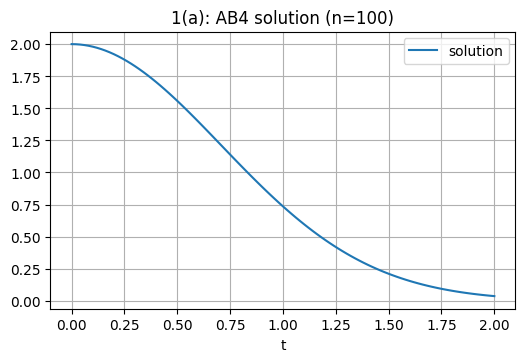

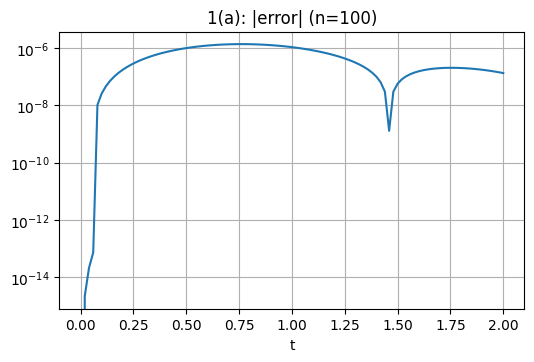

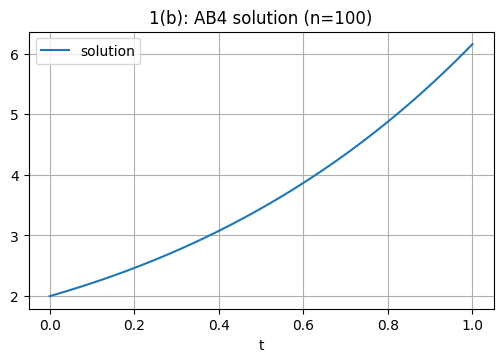

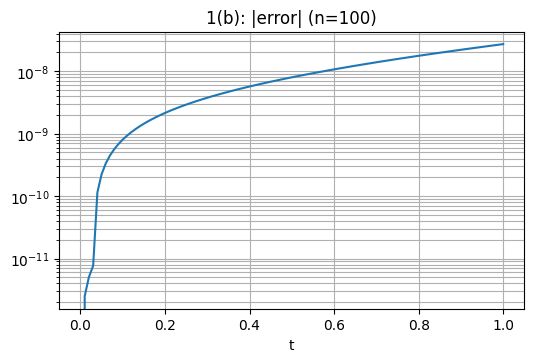

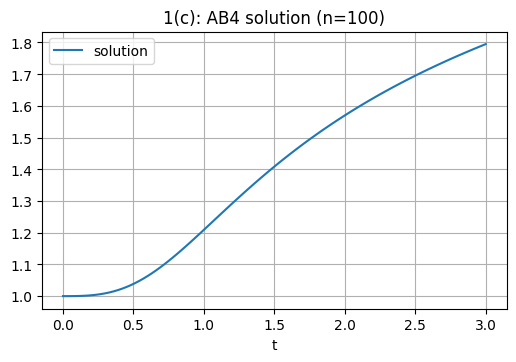

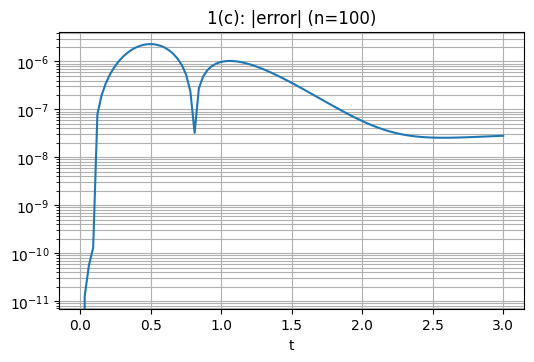

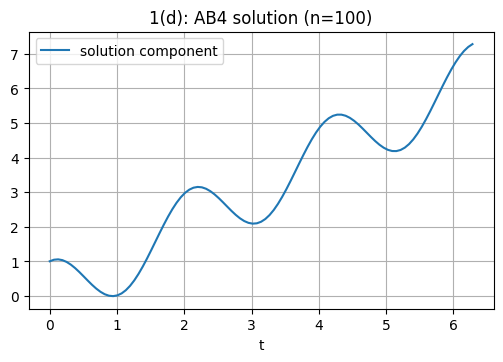

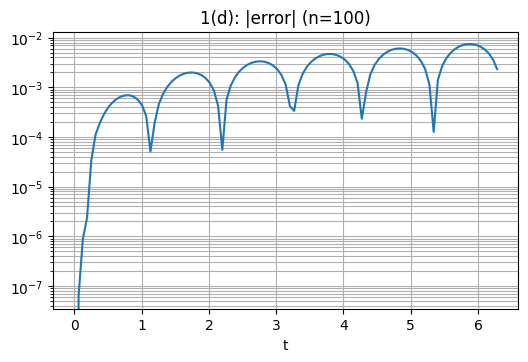

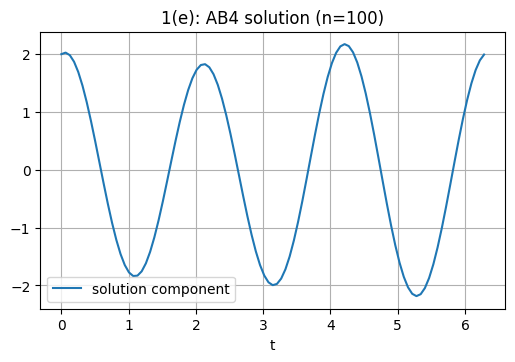

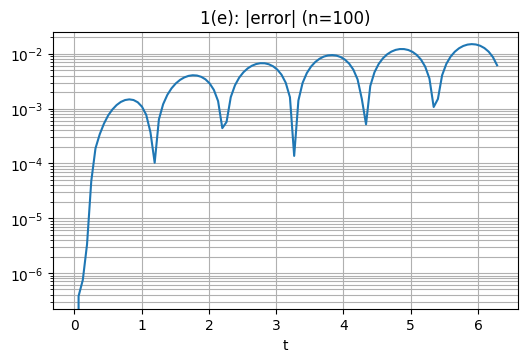

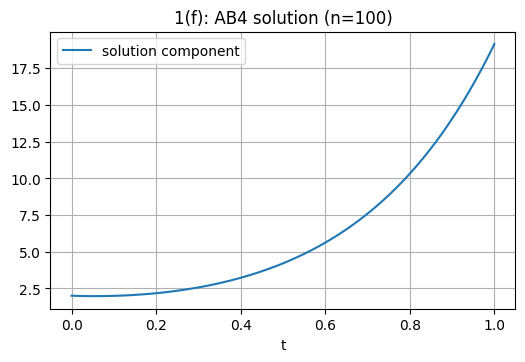

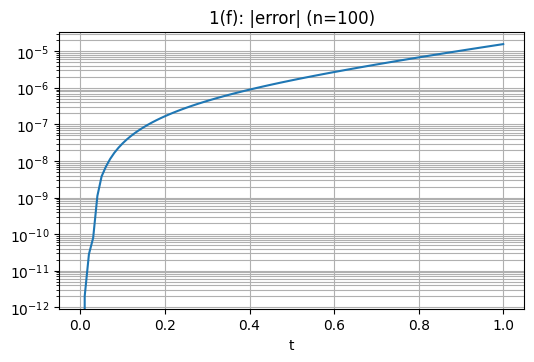

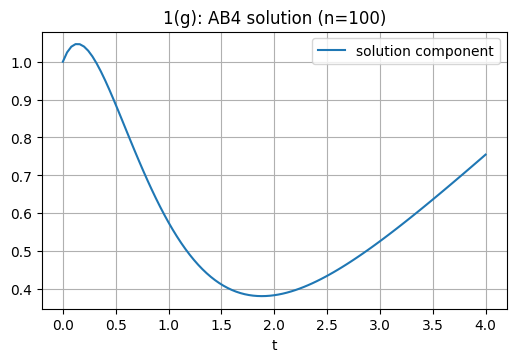

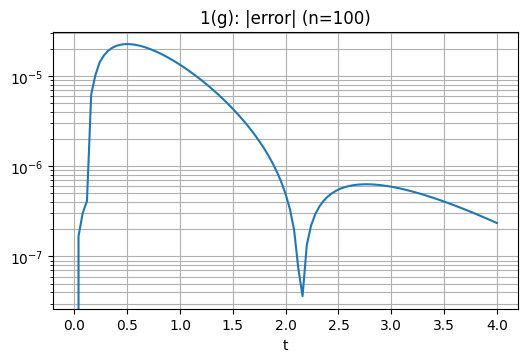

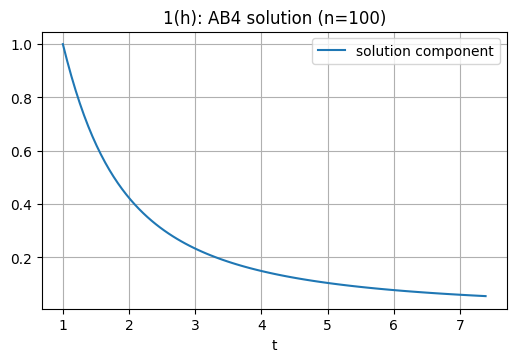

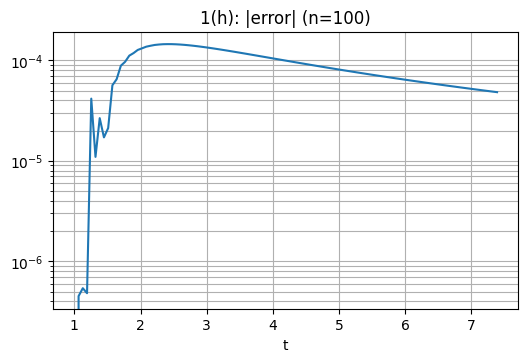

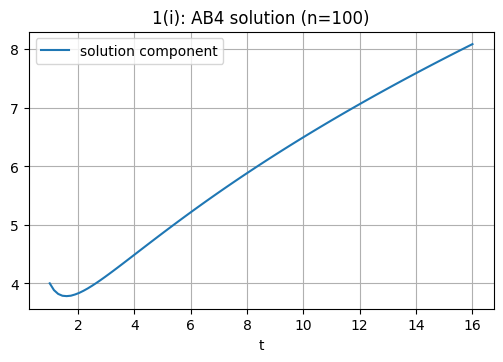

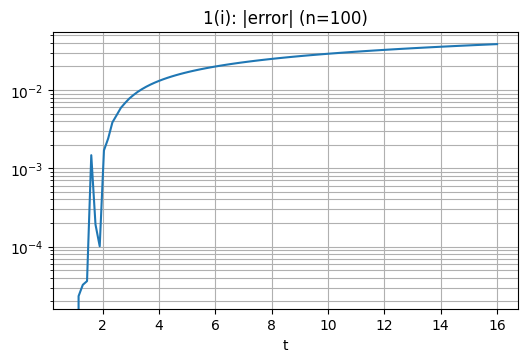

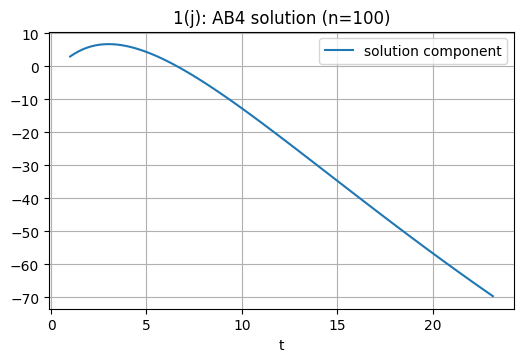

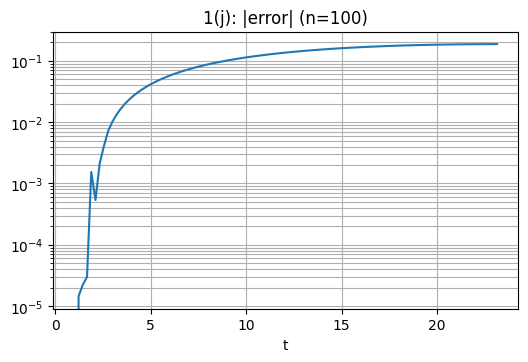

In [3]:

for tag, f, span, u0, errfun in problems:
    t, U = ab4(f, span, u0, n=100)
    # solution plot
    plt.figure(figsize=(6,3.6))
    if U.ndim>1:
        plt.plot(t, U[:,0], label='solution component')
    else:
        plt.plot(t, U, label='solution')
    plt.title(f"{tag}: AB4 solution (n=100)")
    plt.xlabel('t'); plt.grid(True); plt.legend(); plt.show()

    # error plot
    e = errfun(t, U if U.ndim==1 else U)
    plt.figure(figsize=(6,3.6))
    plt.plot(t, np.abs(e))
    plt.title(f"{tag}: |error| (n=100)")
    plt.xlabel('t'); plt.yscale('log'); plt.grid(True, which='both'); plt.show()


## Exercise 2 — AB4 final-time error vs n (powers of two); show O(n^-4) reference

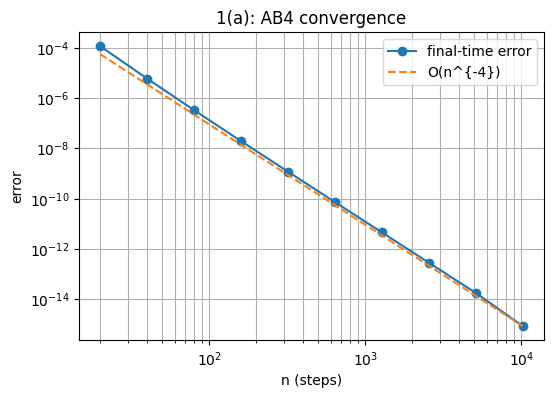

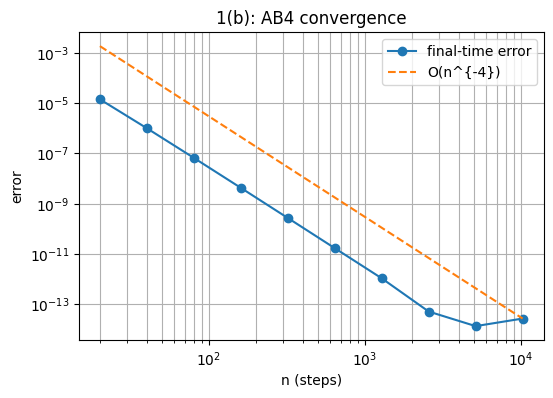

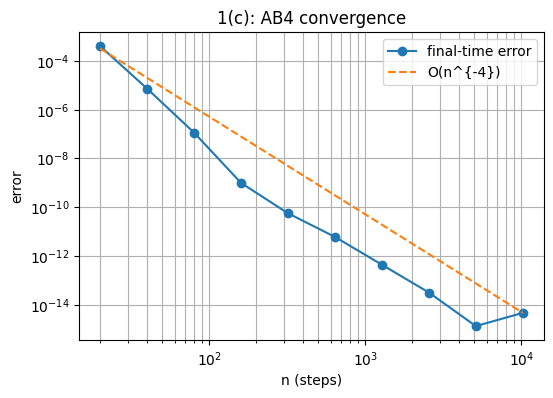

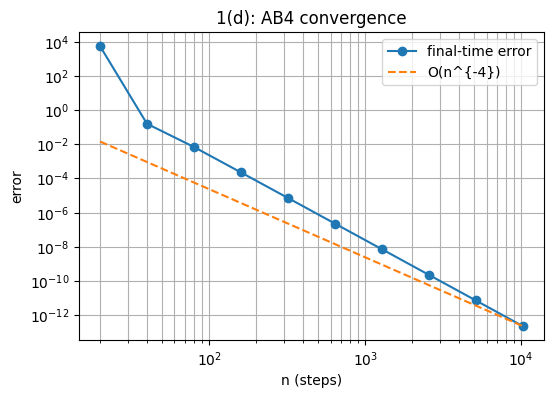

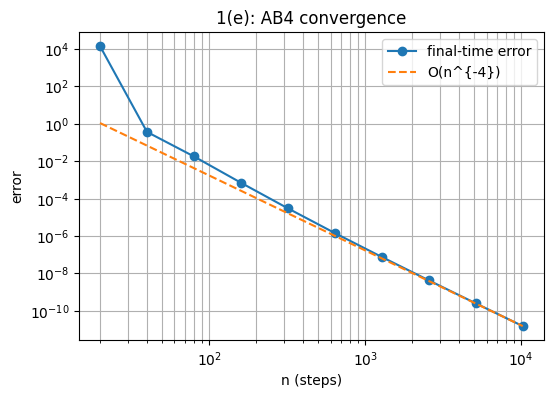

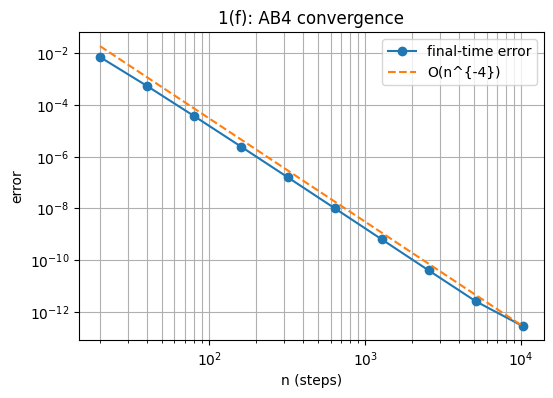

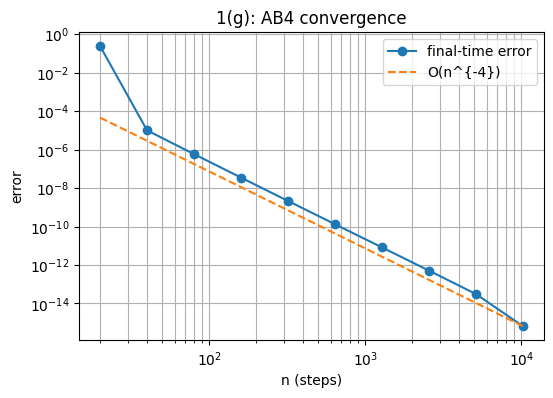

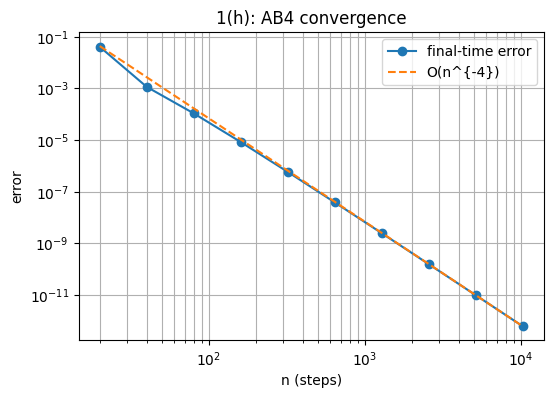

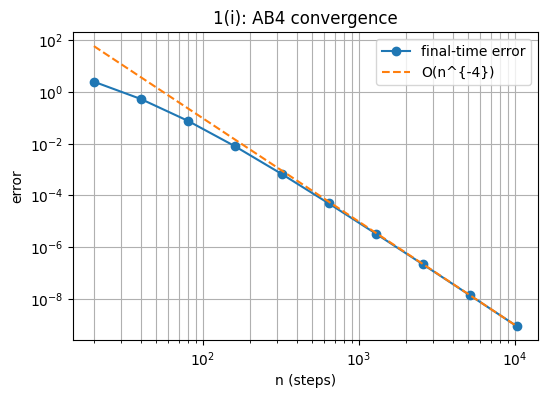

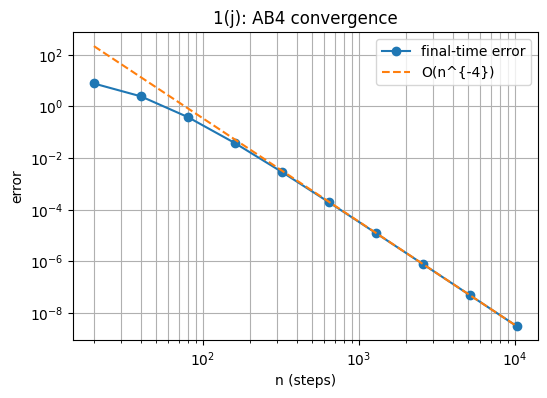

In [4]:

for tag, f, span, u0, errfun in problems:
    Ns = [10*(2**d) for d in range(1, 11)]
    errs = []
    for n in Ns:
        t, U = ab4(f, span, u0, n)
        e = errfun(np.array([t[-1]]), U if U.ndim==1 else U)[-1]
        errs.append(abs(e))
    loglog_with_ref(Ns, errs, slope=4, title=f"{tag}: AB4 convergence")


## Exercise 3 — Repeat Exercise 1 using AM2 (Function 6.7.3 analogue)

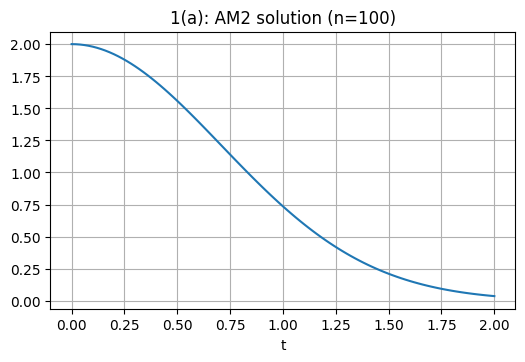

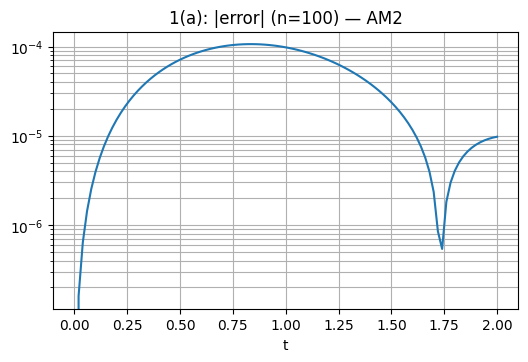

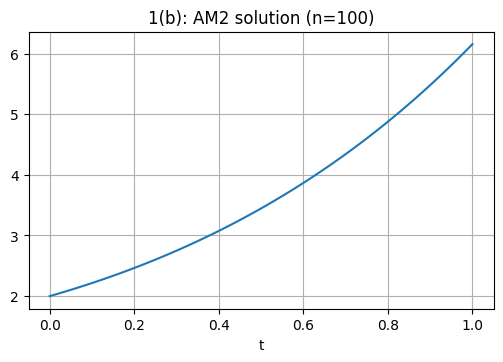

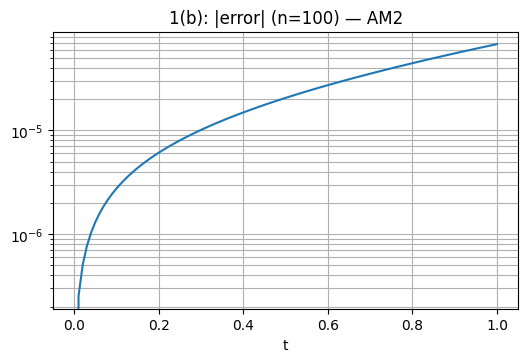

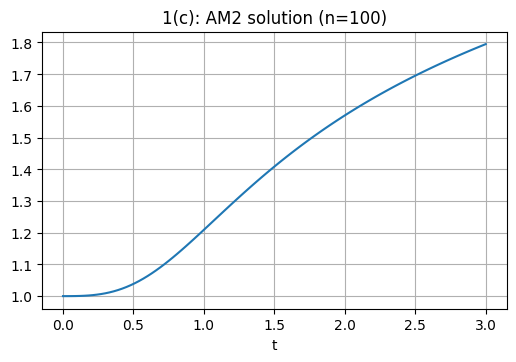

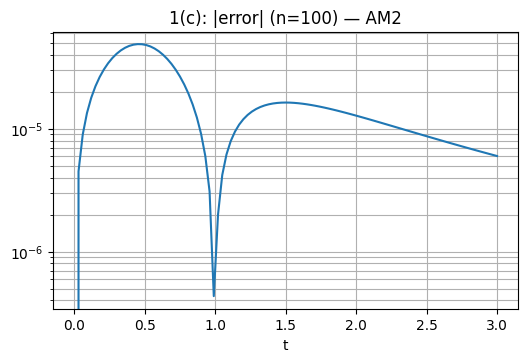

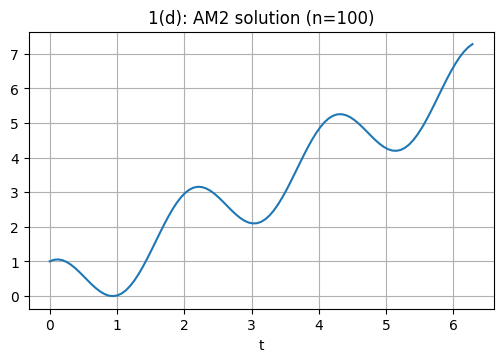

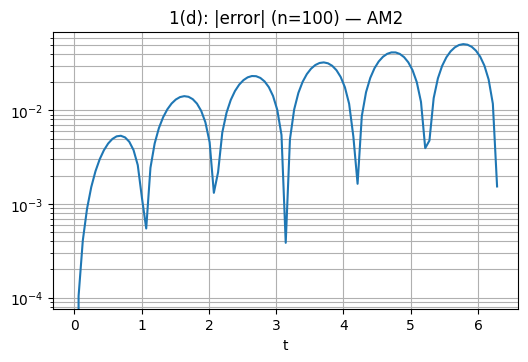

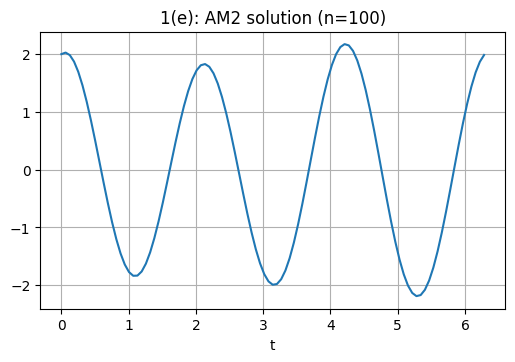

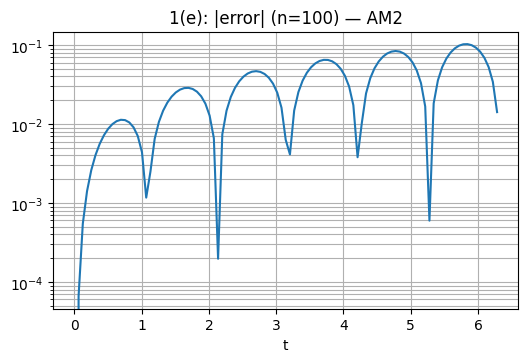

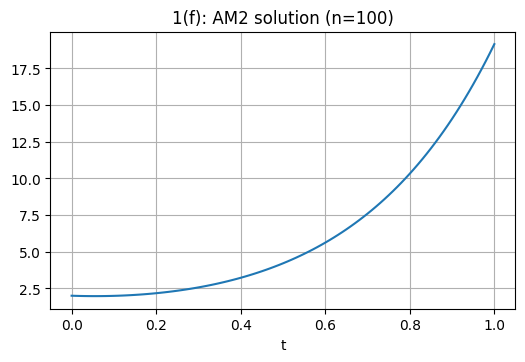

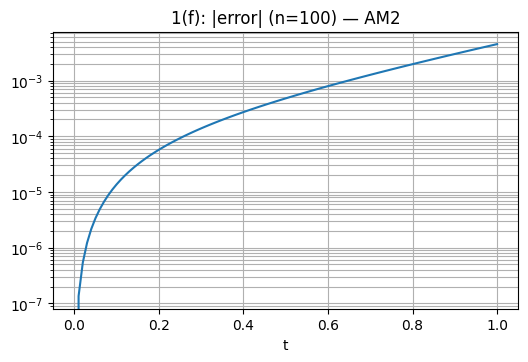

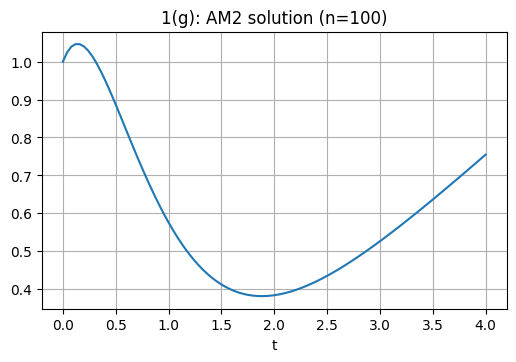

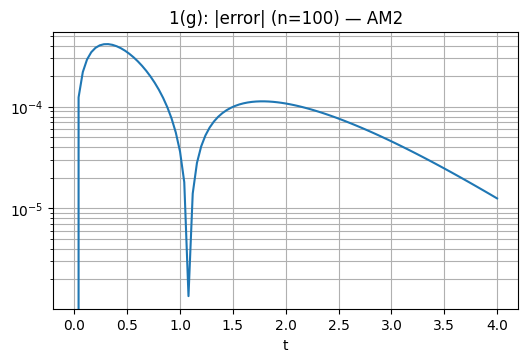

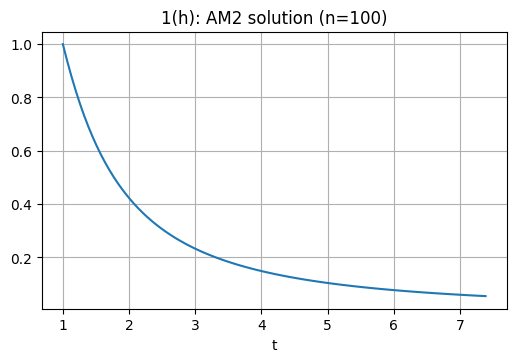

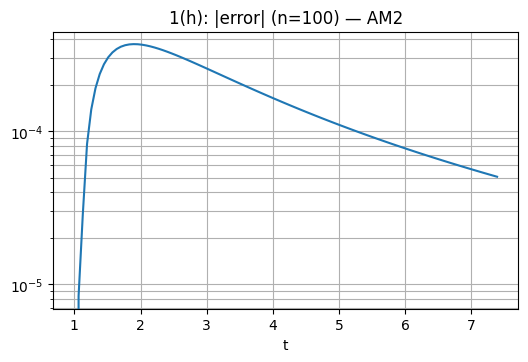

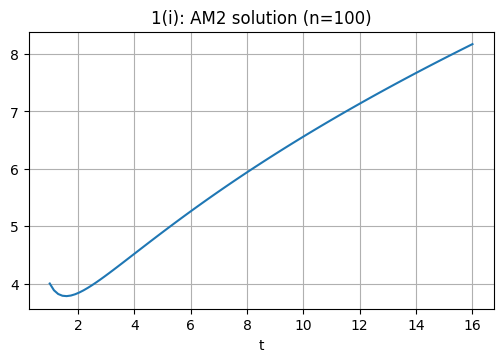

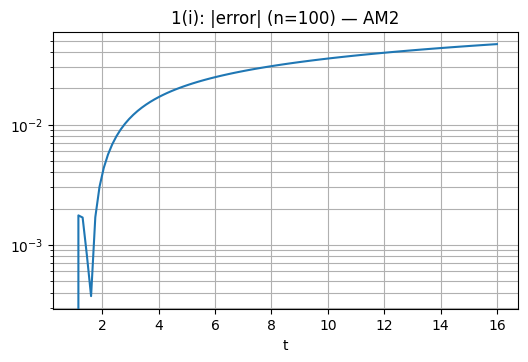

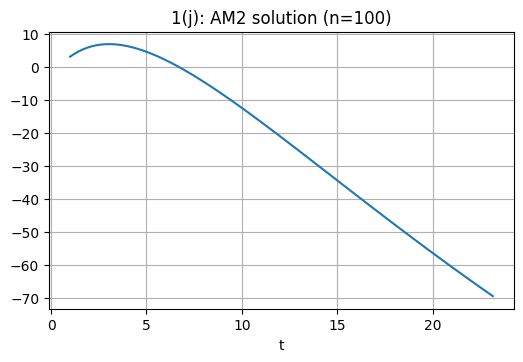

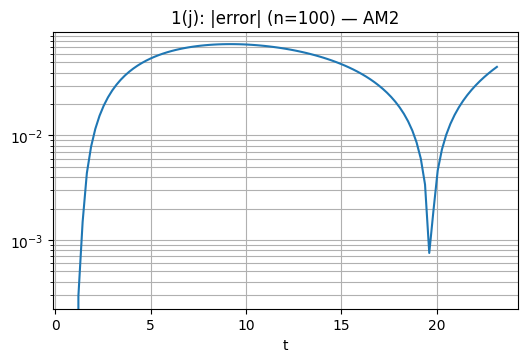

In [5]:

for tag, f, span, u0, errfun in problems:
    t, U = am2(f, span, u0, n=100)
    # solution
    plt.figure(figsize=(6,3.6))
    plt.plot(t, U[:,0] if U.ndim>1 else U)
    plt.title(f"{tag}: AM2 solution (n=100)")
    plt.xlabel('t'); plt.grid(True); plt.show()

    # error
    e = errfun(t, U if U.ndim==1 else U)
    plt.figure(figsize=(6,3.6))
    plt.plot(t, np.abs(e))
    plt.title(f"{tag}: |error| (n=100) — AM2")
    plt.xlabel('t'); plt.yscale('log'); plt.grid(True, which='both'); plt.show()


## Exercise 4 — AM2 final-time error vs n; show O(n^-2) reference

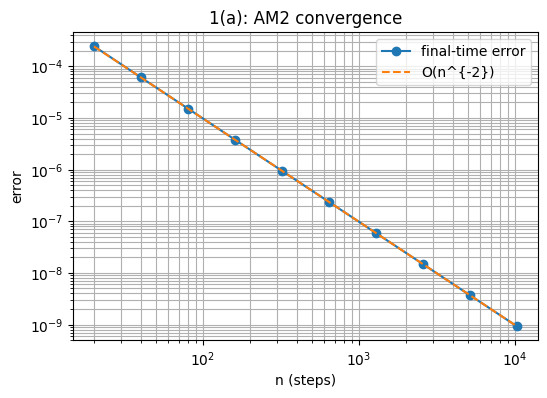

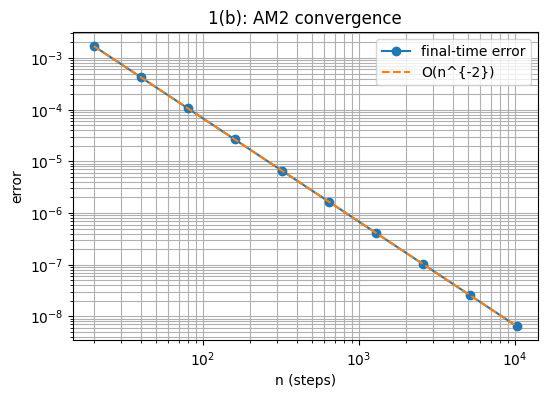

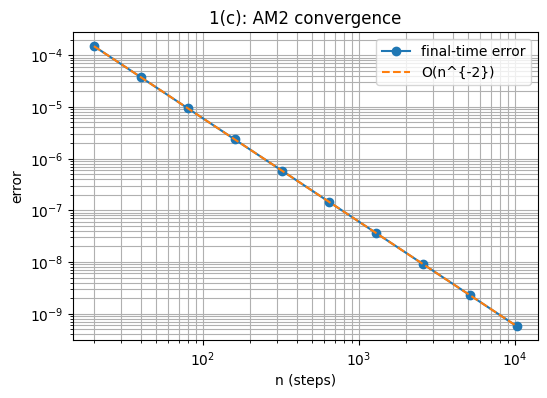

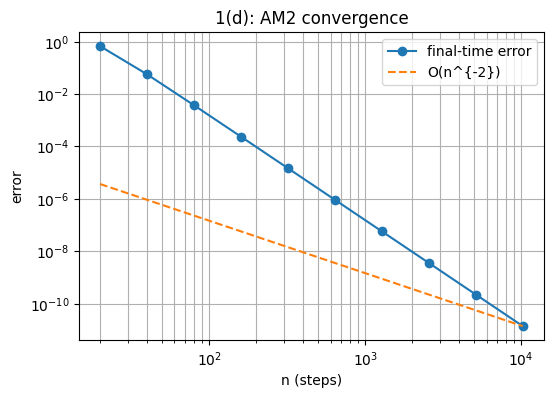

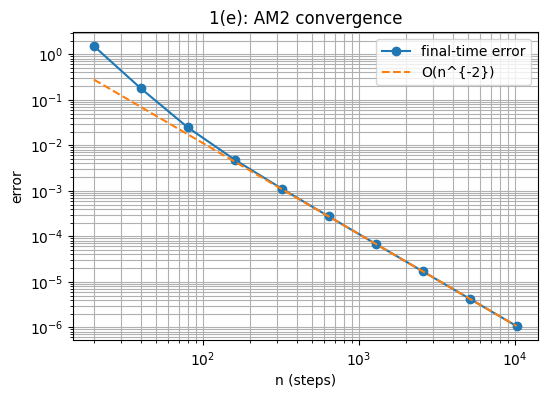

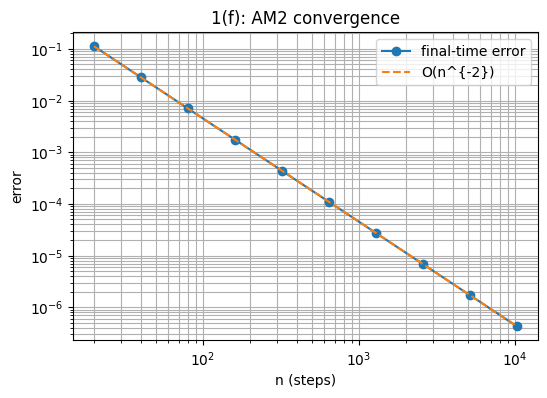

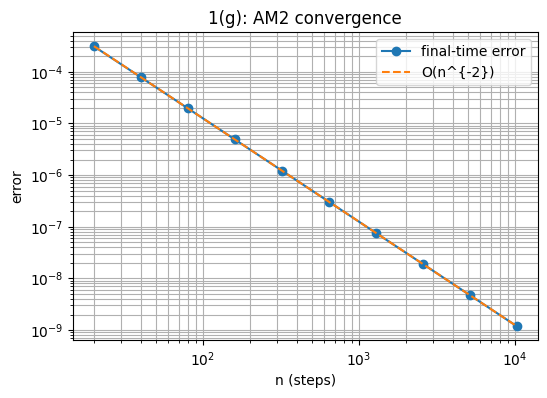

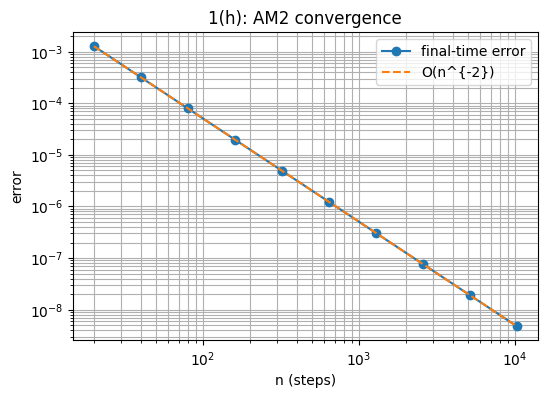

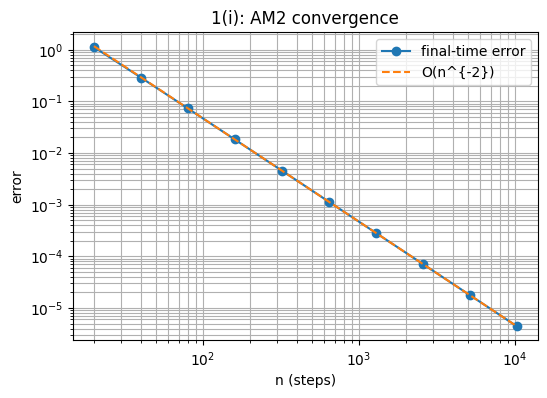

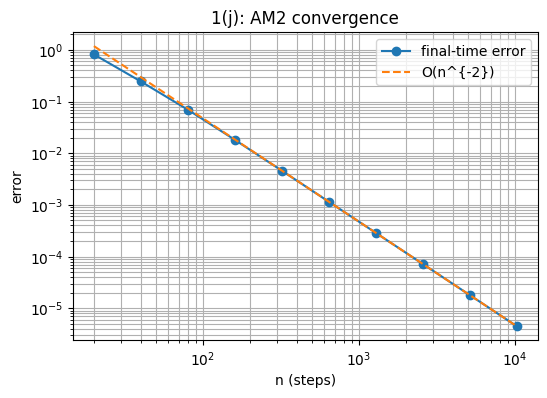

In [6]:

for tag, f, span, u0, errfun in problems:
    Ns = [10*(2**d) for d in range(1, 11)]
    errs = []
    for n in Ns:
        t, U = am2(f, span, u0, n)
        e = errfun(np.array([t[-1]]), U if U.ndim==1 else U)[-1]
        errs.append(abs(e))
    loglog_with_ref(Ns, errs, slope=2, title=f"{tag}: AM2 convergence")


## Exercise 5 — Implement BD2 and test convergence on 1(a)

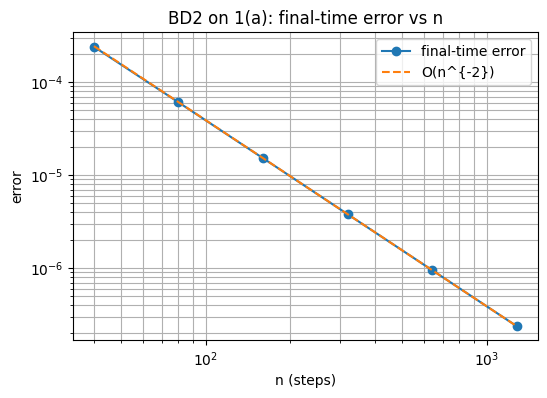

In [7]:

tag, f, span, u0, errfun = problems[0]  # 1(a)
Ns = [40, 80, 160, 320, 640, 1280]
errs = []
for n in Ns:
    t, U = bd2(f, span, u0, n)
    e = errfun(np.array([t[-1]]), U if U.ndim==1 else U)[-1]
    errs.append(abs(e))
loglog_with_ref(Ns, errs, slope=2, title="BD2 on 1(a): final-time error vs n")


## Exercise 6 — Demo 6.7.4 IVP: u' = u^2 - u^3, u(0)=0.005, t in [0,400]

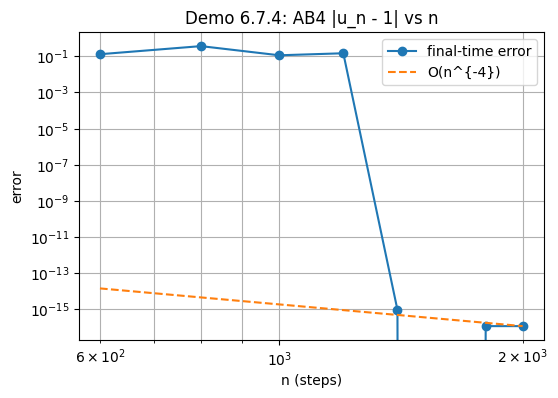

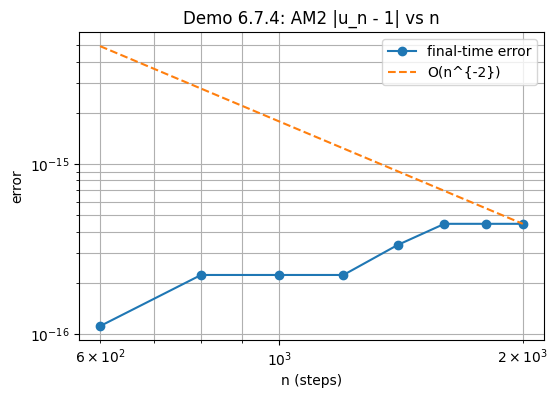

In [8]:

f_demo = lambda t,u: np.asarray(u)**2 - np.asarray(u)**3
span_demo, u0_demo = (0.0, 400.0), np.array([0.005])

# (a) AB4 with n=600..2000
Ns = list(range(600, 2001, 200))
errs = []
for n in Ns:
    t, U = ab4(f_demo, span_demo, u0_demo, n)
    errs.append(abs(U[-1] - 1.0))
loglog_with_ref(Ns, errs, slope=4, title="Demo 6.7.4: AB4 |u_n - 1| vs n")

# (b) AM2 with n=600..2000
errs = []
for n in Ns:
    t, U = am2(f_demo, span_demo, u0_demo, n)
    errs.append(abs(U[-1] - 1.0))
loglog_with_ref(Ns, errs, slope=2, title="Demo 6.7.4: AM2 |u_n - 1| vs n")


## Exercise 7(b–d) — Energy test for u' = A u with A=[[0,-4],[4,0]]

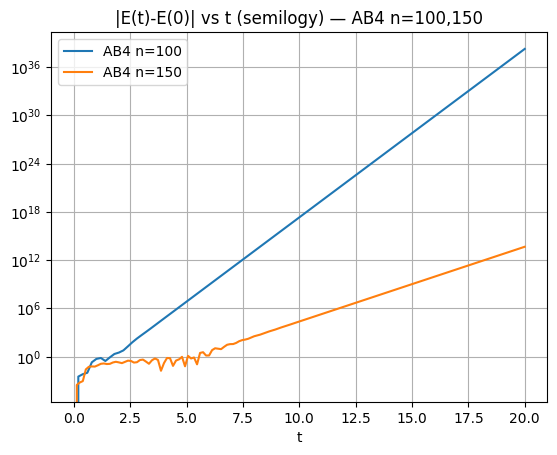

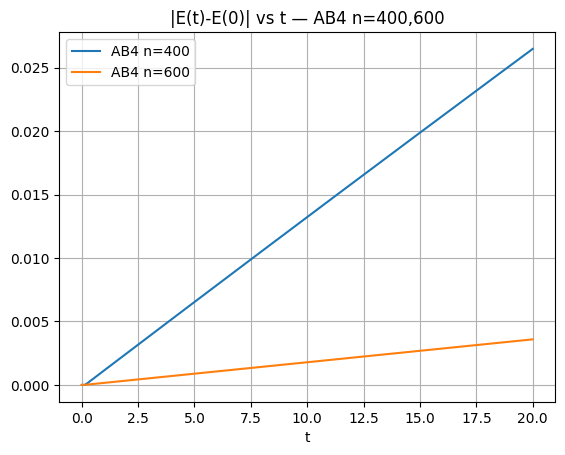

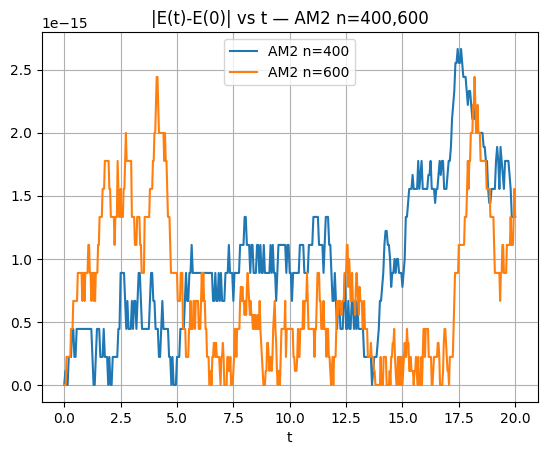

In [9]:

A = np.array([[0.0, -4.0],[4.0, 0.0]])
fA = lambda t,u: A @ _asarray(u)

def energy(U):
    U = np.atleast_2d(U)
    return np.sum(U*U, axis=1)

u0A = np.array([1.0, 0.0])
spanA = (0.0, 20.0)

# (b) AB4, n=100 and n=150; semilogy |E(t)-E(0)|
for n in [100, 150]:
    t, U = ab4(fA, spanA, u0A, n)
    E = energy(U); E0 = E[0]
    plt.semilogy(t, np.abs(E - E0), label=f"AB4 n={n}")
plt.title("|E(t)-E(0)| vs t (semilogy) — AB4 n=100,150")
plt.xlabel("t"); plt.grid(True, which='both'); plt.legend(); plt.show()

# (c) AB4, n=400 and n=600; linear plot
for n in [400, 600]:
    t, U = ab4(fA, spanA, u0A, n)
    E = energy(U); E0 = E[0]
    plt.plot(t, np.abs(E - E0), label=f"AB4 n={n}")
plt.title("|E(t)-E(0)| vs t — AB4 n=400,600")
plt.xlabel("t"); plt.grid(True); plt.legend(); plt.show()

# (d) AM2, n=400 and n=600; linear plot
for n in [400, 600]:
    t, U = am2(fA, spanA, u0A, n)
    E = energy(U); E0 = E[0]
    plt.plot(t, np.abs(E - E0), label=f"AM2 n={n}")
plt.title("|E(t)-E(0)| vs t — AM2 n=400,600")
plt.xlabel("t"); plt.grid(True); plt.legend(); plt.show()


## Exercise 8 — Implement AB2 and repeat 7(b,c)

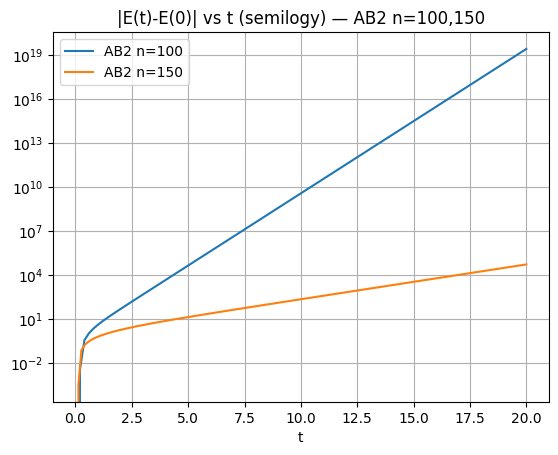

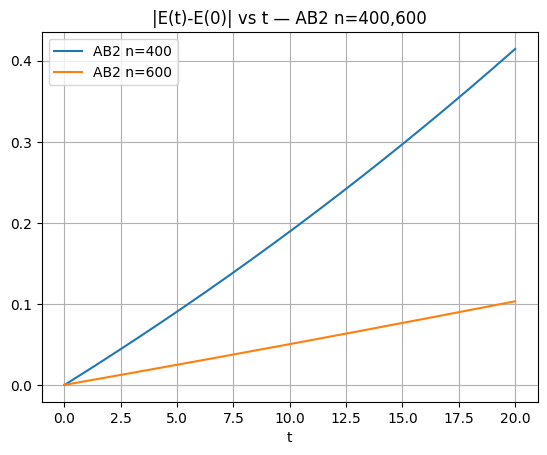

In [10]:

# (a) Done above: ab2
# (b) semilogy with n=100 and 150
for n in [100, 150]:
    t, U = ab2(fA, spanA, u0A, n)
    E = energy(U); E0 = E[0]
    plt.semilogy(t, np.abs(E - E0), label=f"AB2 n={n}")
plt.title("|E(t)-E(0)| vs t (semilogy) — AB2 n=100,150")
plt.xlabel("t"); plt.grid(True, which='both'); plt.legend(); plt.show()

# (c) linear with n=400 and 600
for n in [400, 600]:
    t, U = ab2(fA, spanA, u0A, n)
    E = energy(U); E0 = E[0]
    plt.plot(t, np.abs(E - E0), label=f"AB2 n={n}")
plt.title("|E(t)-E(0)| vs t — AB2 n=400,600")
plt.xlabel("t"); plt.grid(True); plt.legend(); plt.show()


## Exercise 9 — Implement AM1 (Backward Euler) and repeat 7(d) with n=400,800

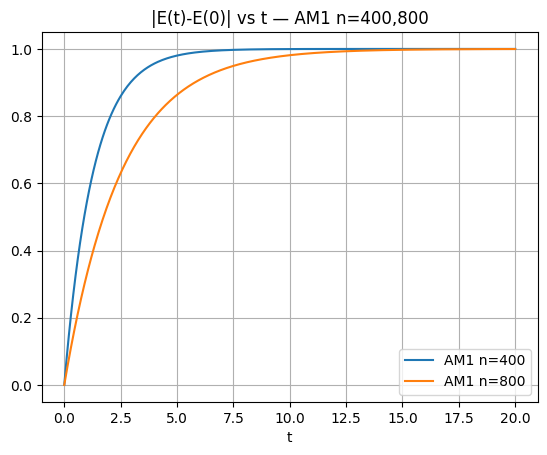

In [11]:

# (a) Done above: am1
# (b) Energy test with AM1
for n in [400, 800]:
    t, U = am1(fA, spanA, u0A, n)
    E = energy(U); E0 = E[0]
    plt.plot(t, np.abs(E - E0), label=f"AM1 n={n}")
plt.title("|E(t)-E(0)| vs t — AM1 n=400,800")
plt.xlabel("t"); plt.grid(True); plt.legend(); plt.show()
